# APPLIED CAPSTONE PROJECT : FINDING THE BEST LOCATION TO OPEN A IZAKAYA IN PARIS

In this study, we will determine the ideal location to open an izakaya in Paris. The izakaya is a kind of Japanese style tapas bar, where you can eat and drink. You usually meet there in the evening with your friends or colleagues in a relaxed atmosphere. </br>

we will try do make some clusters of a district in Paris. We will have to extract some data from a web page, clean it and turn it into database. Use some request on Foursquare to get informations about the places and then make some clusters with the K-means method.

## I) INTRODUCTION

Opening a restaurant is a project that requires a lot of work and investment. It requires a preliminary study to maximize the chances of success of the structure. The study of the location and the customers are necessary.

### a) Location Survey

1) Choose a place where the competition is well "balanced": The area should not have a huge number of Japanese restaurants to avoid competition, but it should also not be empty of restaurants. A group of restaurants makes the area more attractive for customers.

2) Evaluate the flow of possible customers in the area.

3) Among the group of restaurants in the area, check if a Japanese restaurant is famous. Propose a different offer so as to avoid direct competition and to build customer loyalty.

### b) Customers Survey

1) Check the profile of the customers in the area to determine if the location is good for the izakaya concept. 

### c) Hypothesis

For this study, some hypothesis will be made to help clarify our focus.

1) The main target group for this type of restaurant is mainly the young working population between 18 and 35 years of age. the izakaya should be open to all financially, have an affordable price range. 

2) Tripadvisor data will be used for our study. Let's suppose that the data on this ranling website is trustworthy.

3) Based on the Tripadvisor data, a famous restaurant will be defined by its number of reviews and its rating on Tripadvisor. A restaurant is famous when its rating is higher than 4, and its number of reviews higher than 30.

4) The study will use the database shared in 2018 in Kaggle

## II) NEEDED DATA

1) A dataset of the restaurants in Paris with the following information: Name of the restaurants, Address, Price Range, Number of reviews, Reviews, Rating, Latitude, longitude.

2) The number of residents of every district in Paris and their profiles: Average wage for households, age. 

3) Returned data by Foursquare API or others

## III) Getting & Cleaning Data

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import csv

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


### a) Getting Data

On kaggle, some datasets are shared by users for data analysis. I found one dataset published, where 20 000+ restaurants were extracted from Tripadvisors in 2018. The dataset is not directly usable and need some cleaning. Also, there is no address of the restaurants. We will have to extract all the address of the from Tripadvisor.</br>

URL: https://www.kaggle.com/damienbeneschi/krakow-ta-restaurans-data-raw

#### Address Extraction

The first step will be to scrap all the address' of restaurants in Paris and match the data with the existing database shared on Kaggle.

The first difficulty of restaurants' address scraping is to get all the URL of all restaurants in Paris. One way to do that is to visit the link for robots http://www.tripadvisor.com/robots.txt and find the general sitemap. then download all the sub website related to french restaurants "fr-restaurant_review". Download all the gz file s and keep only the links related to restaurants in Ile de France "Paris_Ile_de_France.html".

The following code was used to extract the name and the address of the restaurants on Triadvisor website in a csv file called Tripadvisor_Address. BeatutifulSoup library is used. The file restaurants_link has all the links related to restaurants in Ile de France (extracted and clean at the previous stage). 

In [50]:
import pandas as pd
import csv
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup
import os

In [51]:
os.chdir('/Users/davidhinh/Desktop/IBM Data Science courses')

In [52]:
filename = 'Tripadvisor_Address.csv'
f = open(filename, 'w')

In [ ]:
url2 = '/Users/davidhinh/Desktop/restaurants_url.csv'
file2 = pd.read_csv(url2, header = None)
url = 0

In [ ]:
headers = 'Restaurant Name, Address \n '
f.write(headers)
count = 0

In [ ]:
for i in range(len(file2)+1):
    url = file2[0][i]

    uClient = uReq(url)
    page_html = uClient.read()
    uClient.close()
    page_soup = soup(page_html, 'html.parser')
   
    restaurant_containers = page_soup.findAll('h1', {'class':'restaurants-detail-top-info-TopInfo__restaurantName--1IKBe'})
    if len(restaurant_containers)== 0:
        restaurant_name = 'NA'
    elif len(restaurant_containers) != 0 :
        restaurant_name = restaurant_containers[0].text
    
    address_container = page_soup.findAll('span', {'class':'restaurants-detail-overview-cards-LocationOverviewCard__detailLinkText--co3ei'})
    if len(address_container) == 0:
        address = 'NA'
    elif len(address_container) != 0:
        address = address_container[0].text
    
    f.write(restaurant_name + ',' + address.replace(",","-") + '\n' )
    count = count + 1
    print(count)
    

In [53]:
f.close()

#### Latitude and longitude coordinates

To convert very fast address into latitude and longitude coordinates, I used this following french website: 
https://adresse.data.gouv.fr/csv

#### Information related to the customers profile

All the information related to the customers profile such as average wage for households for each district in Paris, number of population are found on the french website https://insee.fr/ (The National Institute of Statistics and Economic Studies collects, produces, analyses and disseminates information on the French economy and society).

##### Average Wage per households & number of inhabitants per district

In [2]:
wagepop = {'Postal Code':['75001','75002','75003','75004','75005','75006','75007','75008','75009','75010','75011','75012','75013','75014','75015','75016','75017','75018','75019','75020'],
        'District Average Wage Per Household €':['2862','2724','2803','2733','2972','3515','3896','3739','2974','2195','2312','2343','2023','2394','2695','3509','2670','1766','1552','1721'],
        'District population 2018':['16545','20796','35049','27146','59333','42428','54133','36694','59408','91770','149834','142340','183216','139992','234994','165487','168533','197580','185654','195556']}

In [4]:
dfwagepop=pd.DataFrame(wagepop, columns = ['Postal Code', 'District Average Wage Per Household €','District population 2018' ])
dfwagepop

,Postal Code,District Average Wage Per Household €,District population 2018
0,75001,2862,16545
1,75002,2724,20796
2,75003,2803,35049
3,75004,2733,27146
4,75005,2972,59333
5,75006,3515,42428
6,75007,3896,54133
7,75008,3739,36694
8,75009,2974,59408
9,75010,2195,91770


##### Age of the population

In [5]:
age = {'Age':['0-14','15-29','30-44','45-49','60-74','75+'],
       '75001': ['11.8','22.1','22.7','20.3','14.9','8.1'],
       '75002': ['12','26.2','27.3','19.8','10.6','4.1'],
       '75003': ['11.4','25.9','25.2','19.2','12.5','5.8'],
       '75004': ['11.4','24.5','21.6','19.3','15.3','7.8'],
       '75005': ['11.4','29.2','17.3','16.9','15.5','9.5'],
       '75006': ['10.2','27.6','16.4','16.9','17.3','11.5'],
       '75007': ['12.1','23.6','17.3','18.2','17.3','11.5'],
       '75008': ['15.1','23.7','20.2','18.7','14.8','7.6'],
       '75009': ['14','25','25.4','17.8','11.8','6'],
       '75010': ['14.9','23.5','26.7','18.5','11.4','4.9'],
       '75011': ['12','24.7','25.4','17.8','13.6','6.5'],
       '75012': ['13.4','22.7','22.4','18.5','14.3','8.7'],
       '75013': ['13.7','23.7','20.3','19','15.2','8.1'],
       '75014': ['12.6','26.3','19.9','17.2','15.1','8.9'],
       '75015': ['13.6','24.2','21.4','17.6','14.3','8.9'],
       '75016': ['14.6','20.8','17.1','19.7','16.3','11.5'],
       '75017': ['14.3','23.9','23.1','17.9','13.5','7.3'],
       '75018': ['14','23.5','26.5','18','12.2','5.8'],
       '75019': ['17','21.9','21.7','19.2','13.7','6.5'],
       '75020': ['15.1','20.9','23.1','20','14.4','6.5']}

In [6]:
dfage = pd.DataFrame(age, columns=['Age','75001','75002','75003','75004','75005','75006','75007','75008','75009','75010','75011','75012','75013','75014','75015','75016','75017','75018','75019','75020'])
dfage

,Age,75001,75002,75003,75004,75005,75006,75007,75008,75009,75010,75011,75012,75013,75014,75015,75016,75017,75018,75019,75020
0,0-14,11.8,12,11.4,11.4,11.4,10.2,12.1,15.1,14,14.9,12,13.4,13.7,12.6,13.6,14.6,14.3,14,17,15.1
1,15-29,22.1,26.2,25.9,24.5,29.2,27.6,23.6,23.7,25,23.5,24.7,22.7,23.7,26.3,24.2,20.8,23.9,23.5,21.9,20.9
2,30-44,22.7,27.3,25.2,21.6,17.3,16.4,17.3,20.2,25.4,26.7,25.4,22.4,20.3,19.9,21.4,17.1,23.1,26.5,21.7,23.1
3,45-49,20.3,19.8,19.2,19.3,16.9,16.9,18.2,18.7,17.8,18.5,17.8,18.5,19,17.2,17.6,19.7,17.9,18,19.2,20
4,60-74,14.9,10.6,12.5,15.3,15.5,17.3,17.3,14.8,11.8,11.4,13.6,14.3,15.2,15.1,14.3,16.3,13.5,12.2,13.7,14.4
5,75+,8.1,4.1,5.8,7.8,9.5,11.5,11.5,7.6,6,4.9,6.5,8.7,8.1,8.9,8.9,11.5,7.3,5.8,6.5,6.5


### b) Cleaning Data

The shared database on Kaggle have to be cleaned to be usable. 

In [ ]:
urlold = '/Users/davidhinh/Desktop/IBM Data Science courses/TA_restaurants_curated.csv'
df = pd.read_csv(urlold)
df.head()

Selecting the only data that we are interested in: Restaurants located in Paris

In [ ]:
dfparis = df[df['City'] == 'Paris']
dfparis.reset_index(drop = True, inplace = True)
dfparis.head()

We can drop the data that are not useful for our study. The ranking column from the database doesn't give the real ranking of restaurants in paris, but only its position in the database.

In [ ]:
dfparis.drop(columns = ['Unnamed: 0', 'Ranking', 'URL_TA', 'ID_TA'], inplace = True)
dfparis.head()

By using Excel, I converted the columns into string type instead of a list to make it easier to use the database later on.

The final version of the cleaned database is available here:
/Users/davidhinh/Desktop/Capstone Project /FinalTripadvisor_Paris.csv</br>

The file Restaurants_geocode has the name, address, postal code, latitude and longitude coordinates of the extracted restaurants.

### c) Merging Data

In [8]:
url = '/Users/davidhinh/Desktop/Restaurant Data Base/FinalTripadvisor_Paris.csv'
read = pd.read_csv(url)
read.head(20)

,Unnamed: 0,Name,City,Cuisine Style,Rating,Price Range,Number of Reviews,Reviews
0,0,La Meduse,Paris,French - Seafood - European - Vegetarian Frien...,5.0,$$ - $$$,178.0,You cant figure out from the outside the
1,1,Le Cappiello,Paris,French - Mediterranean - European - Contempora...,5.0,$$ - $$$,208.0,Incredible! - Amazing food - wonderful atmosph...
2,2,ASPIC,Paris,French - European - Contemporary,5.0,$$$$,427.0,Second time and just as good - Best dinner in ...
3,3,Les Apotres de Pigalle,Paris,South American - Brew Pub - European - Vegetar...,5.0,$$ - $$$,1152.0,Wonderful culinary experience - Must go restau...
4,4,Epicure,Paris,French - European - Vegetarian Friendly - Vega...,5.0,$$$$,2305.0,Very nice place - Speechless
5,5,Sourire Le Restaurant,Paris,French - European - Contemporary - Gastropub,5.0,$$$$,198.0,Great service - Just excellent
6,6,Le Cinq,Paris,French - European - Vegetarian Friendly - Vega...,4.5,$$$$,1887.0,Breath taking ambience and great service - Gra...
7,7,Il Etait Un Square,Paris,French - Steakhouse - Vegetarian Friendly,5.0,$$ - $$$,1600.0,Excellent dining experience - Great burgers
8,8,Boutary,Paris,French - Seafood - Gastropub - European - Fusi...,5.0,$$$$,533.0,They will get the star for 2 reasons - A fanta...
9,9,Kei Restaurant,Paris,French - Vegetarian Friendly - Gluten Free Opt...,4.5,$$$$,689.0,Amazing!! - Magnifique


In [9]:
read.shape

(14874, 8)

The file Restaurants_geocode has the name, address, postal code, latitude and longitude coordinates of the extracted restaurants.

In [10]:
url2 = '/Users/davidhinh/Desktop/Restaurant Data Base/Restaurants_geocode.csv'
df= pd.read_csv(url2)
df.head()

,Name,Borough,Neighborhood,Address,Insee Code,Latitude,Longitude
0,La Cucina,Paris 15e,Boulevard Garibaldi,36 Boulevard Garibaldi 75015 Paris,75115.0,48.846662,2.305116
1,Le Reciproque,Paris 18e,Rue Ferdinand Flocon,14 Rue Ferdinand Flocon 75018 Paris,75118.0,48.891625,2.346073
2,NaN,NaN,Nas,NaN,NaN,44.968732,4.691406
3,Hideout Montparnasse FERMé,Paris 14e,Rue de la Gaîté,33 Rue de la Gaîté 75014 Paris,75114.0,48.839248,2.323327
4,Umami Matcha Café,Paris 3e,Rue Béranger,22 Rue Béranger 75003 Paris,75103.0,48.866528,2.363535


Dropping all the missing data

In [11]:
df.dropna(inplace = True)
df.head()

,Name,Borough,Neighborhood,Address,Insee Code,Latitude,Longitude
0,La Cucina,Paris 15e,Boulevard Garibaldi,36 Boulevard Garibaldi 75015 Paris,75115.0,48.846662,2.305116
1,Le Reciproque,Paris 18e,Rue Ferdinand Flocon,14 Rue Ferdinand Flocon 75018 Paris,75118.0,48.891625,2.346073
3,Hideout Montparnasse FERMé,Paris 14e,Rue de la Gaîté,33 Rue de la Gaîté 75014 Paris,75114.0,48.839248,2.323327
4,Umami Matcha Café,Paris 3e,Rue Béranger,22 Rue Béranger 75003 Paris,75103.0,48.866528,2.363535
5,Le Pré Salé,Paris 13e,Rue du Moulin des Prés,22 Rue du Moulin des Prés 75013 Paris,75113.0,48.828559,2.352699


Merging both databases into one based on the name of the restaurants

In [12]:
merge1 = read.merge(df, on='Name', how = 'inner')
merge1.head()

,Unnamed: 0,Name,City,Cuisine Style,Rating,Price Range,Number of Reviews,Reviews,Borough,Neighborhood,Address,Insee Code,Latitude,Longitude
0,2,ASPIC,Paris,French - European - Contemporary,5.0,$$$$,427.0,Second time and just as good - Best dinner in ...,Paris 9e,Rue de la Tour d'Auvergne,24 Rue de la Tour d'Auvergne 75009 Paris,75109.0,48.879179,2.343686
1,3,Les Apotres de Pigalle,Paris,South American - Brew Pub - European - Vegetar...,5.0,$$ - $$$,1152.0,Wonderful culinary experience - Must go restau...,Paris 18e,Rue Germain Pilon,2 Rue Germain Pilon 75018 Paris,75118.0,48.883011,2.336337
2,4,Epicure,Paris,French - European - Vegetarian Friendly - Vega...,5.0,$$$$,2305.0,Very nice place - Speechless,Paris 8e,Rue du Faubourg Saint-honoré,112 Rue du Faubourg Saint-honoré 75008 Paris,75108.0,48.871680,2.314773
3,5,Sourire Le Restaurant,Paris,French - European - Contemporary - Gastropub,5.0,$$$$,198.0,Great service - Just excellent,Paris 13e,Rue de la Santé,15 Rue de la Santé 75013 Paris,75113.0,48.837169,2.342030
4,6,Le Cinq,Paris,French - European - Vegetarian Friendly - Vega...,4.5,$$$$,1887.0,Breath taking ambience and great service - Gra...,Paris 8e,Avenue George V,31 Avenue George V 75008 Paris,75108.0,48.868792,2.300828


Dropping the duplicates, two restaurants cannot have the same address

In [13]:
merge1.drop_duplicates(['Address'], keep = 'first', inplace = True)
merge1.dropna(inplace = True)

Sorting the restaurants based on their popularity (number of reviews)

In [14]:
merge1.drop(columns=['Unnamed: 0'], inplace = True)
merge1.sort_values(by = ['Number of Reviews'], ascending = False, inplace = True)
merge1.head()

,Name,City,Cuisine Style,Rating,Price Range,Number of Reviews,Reviews,Borough,Neighborhood,Address,Insee Code,Latitude,Longitude
982,Le Bouillon Chartier,Paris,French - European,3.5,$,10706.0,Go for the experience! - When in Paris!,Paris 9e,Rue du Faubourg Montmartre,7 Rue du Faubourg Montmartre 75009 Paris,75109.0,48.871924,2.343040
433,Le Jules Verne,Paris,French - European,4.0,$$$$,5313.0,The views and experience overcome the shor,Paris 7e,Avenue Gustave Eiffel,Avenue Gustave Eiffel 75007 Paris,75107.0,48.858189,2.295549
508,Le Train Bleu,Paris,French - Vegetarian Friendly - Vegan Options -...,4.0,$$$$,4432.0,In a gorgeous atmosphere - but the food is,Paris 12e,Place Louis Armand,Place Louis Armand 75012 Paris,75112.0,48.845146,2.372473
1626,La Coupole,Paris,French - European - Soups - Gastropub,3.5,$$ - $$$,3824.0,traditional parisian bistro with 1920s pai,Paris 14e,Boulevard du Montparnasse,102 Boulevard du Montparnasse 75014 Paris,75114.0,48.842300,2.328069
369,L'As du Fallafel,Paris,Fast Food - Mediterranean - Middle Eastern - I...,4.0,$,3820.0,Fun Jewish/Israeli kosher eatery in the Ma,Paris 4e,Rue des Rosiers,34 Rue des Rosiers 75004 Paris,75104.0,48.857413,2.359064


The cuisine style is given by tripadvisor users. Let's assume that there are japanese restaurants behind the label Asian in Cuisine Style column.

In [99]:
japaneserest = merge1.loc[merge1['Cuisine Style'].isin(['Japanese'])]
japaneserest.head()

,Name,City,Cuisine Style,Rating,Price Range,Number of Reviews,Reviews,Borough,Neighborhood,Address,Insee Code,Latitude,Longitude
941,Tonkatsu Tombo,Paris,Japanese,4.5,$$ - $$$,117.0,Katsu don is a must! - Great value for money,Paris 15e,Rue de l'Arrivée,14 Rue de l'Arrivée 75015 Paris,75115.0,48.843298,2.321696
2695,Okomusu Paris,Paris,Japanese,4.0,$$ - $$$,92.0,Nice discovery - Delicious meal!,Paris 3e,Rue Charlot,11 Rue Charlot 75003 Paris,75103.0,48.861460,2.360837
2806,Kazoku,Paris,Japanese,4.0,$,90.0,Great price - good quantity but adequate qu,Paris 14e,Rue de la Tombe Issoire,105 Rue de la Tombe Issoire 75014 Paris,75114.0,48.826053,2.331825
3138,Le Feu de Mars,Paris,Japanese,4.0,$$ - $$$,82.0,Just great food! - great teppanyaki - cheap price,Paris 13e,Rue Vandrezanne,41 Rue Vandrezanne 75013 Paris,75113.0,48.827681,2.353186
4672,Izakaya Taisho Ken 3,Paris,Japanese,4.0,$,73.0,Simply Stunning - Disappointing,Paris 1er,Rue Sainte-anne,11 Rue Sainte-anne 75001 Paris,75101.0,48.866043,2.335302


In [100]:
japaneserest.shape

(113, 13)

The database is now ready. we can finally start the analysis.

## IV) Location Survey

We want first to know the location of the existing japanese restaurants in Paris.

In [17]:
address = 'Paris, France'

geolocator = Nominatim(user_agent="Paris_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris are 48.8566969, 2.3514616.


In [18]:
# create map of Paris using latitude and longitude values
map_paris = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(japaneserest['Latitude'], japaneserest['Longitude'], japaneserest['Borough'], japaneserest['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

We are going to use the Foursquare API to explore the neighborhoods and segment them. 
First, we define Foursquare credentials and version

In [19]:
CLIENT_ID = '1NGJHWOA5HWK1YPCTGWIWBOCXC5UI1RVRXDL5IDA1B1S24J1' # your Foursquare ID
CLIENT_SECRET = 'MQV0X2TN5DYKD05OBKKG32QXH1GHERFDKSTF5ECPVFNIMRJW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1NGJHWOA5HWK1YPCTGWIWBOCXC5UI1RVRXDL5IDA1B1S24J1
CLIENT_SECRET:MQV0X2TN5DYKD05OBKKG32QXH1GHERFDKSTF5ECPVFNIMRJW


In [20]:
LIMIT = 100
radius = 500

url3 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

url3

'https://api.foursquare.com/v2/venues/explore?&client_id=1NGJHWOA5HWK1YPCTGWIWBOCXC5UI1RVRXDL5IDA1B1S24J1&client_secret=MQV0X2TN5DYKD05OBKKG32QXH1GHERFDKSTF5ECPVFNIMRJW&v=20180605&ll=48.8566969,2.3514616&radius=500&limit=100'

We send the GET request and get the results.

In [21]:
results = requests.get(url3).json()
results

{'meta': {'code': 200, 'requestId': '5f12c82f40a5a740768ed60e'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Hôtel-de-Ville',
  'headerFullLocation': 'Hôtel-de-Ville, Paris',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 132,
  'suggestedBounds': {'ne': {'lat': 48.861196904500005,
    'lng': 2.3582883184847447},
   'sw': {'lat': 48.8521968955, 'lng': 2.344634881515255}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bf41231e5eba59334341f90',
       'name': "Place de l'Hôtel de Ville – Esplanade de la Libération",
       'location': {'address': "Place de l'Hôtel de Ville",
        'lat': 48.85692475726913,
        'lng': 2.3514118156673676,
        'distanc

In [22]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We have to clean the Json and structure it into a pandas dataframe.

In [24]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Place de l'Hôtel de Ville – Esplanade de la Li...,Plaza,48.856925,2.351412
1,Parc Rives de Seine,Park,48.855510,2.351419
2,Berges de Seine – Rive droite,Pedestrian Plaza,48.855131,2.352289
3,L'Alsacien,Alsatian Restaurant,48.858275,2.350381
4,BHV Marais,Department Store,48.857312,2.353633


In [25]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


### Exploring neighbourhood in Paris

In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [28]:
Paris_venues = getNearbyVenues(names=japaneserest['Neighborhood'],
                                   latitudes=japaneserest['Latitude'],
                                   longitudes=japaneserest['Longitude']
                                  )

Rue de l'Arrivée
Cité de l'Ameublement
Rue Charlot
Rue de la Tombe Issoire
Avenue de Choisy
Rue Vandrezanne
Avenue de Choisy
Rue Sainte-anne
Rue de la Roquette
Rue Brey
Rue de Vaugirard
Rue Saint-maur
Rue d'Odessa
Boulevard de Charonne
Rue Françoise Dolto
Rue du Faubourg Saint-martin
Rue de Lévis
Avenue du Maine
Rue Guillaume Bertrand
Avenue de Choisy
Rue Caulaincourt
Rue Saint-augustin
Avenue Bosquet
Rue Claude Decaen
Rue des Lyanes
Rue Sainte-anne
Rue Nationale
Boulevard de Picpus
Rue Etienne Marcel
Rue de Mogador
Boulevard de Picpus
Rue du Pot de Fer
Rue Greneta
Rue de Ponthieu
Rue Danielle Casanova
Rue de la Verrerie
Rue du Maine
Rue de l'Annonciation
Avenue Jean Jaurès
Rue Montmartre
Rue Biot
Rue Mathurin Régnier
Rue de Longchamp
Rue de Ponthieu
Rue Alibert
Rue Beaurepaire
Rue de la Roquette
Rue de l'Arc de Triomphe
Rue Saint-honoré
Rue Louis Bonnet
Boulevard Haussmann
Rue de Villafranca
Rue du Faubourg Poissonnière
Rue Médéric
Rue Leibniz
Rue Troyon
Boulevard de Vaugirard
Rue Fra

In [29]:
Paris_venues.shape

(11252, 7)

In [30]:
Paris_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rue de l'Arrivée,48.843298,2.321696,Observatoire Panoramique de la Tour Montparnasse,48.842155,2.321926,Scenic Lookout
1,Rue de l'Arrivée,48.843298,2.321696,Musée Bourdelle,48.843180,2.318673,Museum
2,Rue de l'Arrivée,48.843298,2.321696,Le Clos Y,48.843069,2.320700,Japanese Restaurant
3,Rue de l'Arrivée,48.843298,2.321696,Les Fauves,48.841937,2.322581,Comfort Food Restaurant
4,Rue de l'Arrivée,48.843298,2.321696,Hôtel Louison (Ex-Aviatic Saint-Germain),48.845321,2.321345,Hotel


In [31]:
Paris_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Avenue Bosquet,100,100,100,100,100,100
Avenue Corentin Cariou,44,44,44,44,44,44
Avenue Jean Jaurès,117,117,117,117,117,117
Avenue Jean Moulin,66,66,66,66,66,66
Avenue Parmentier,91,91,91,91,91,91
Avenue de Choisy,282,282,282,282,282,282
Avenue de Villiers,51,51,51,51,51,51
Avenue de la Porte de Choisy,45,45,45,45,45,45
Avenue de la République,100,100,100,100,100,100


## Analyze each neighborhood with one hot encoding

In [32]:
# one hot encoding
Paris_onehot = pd.get_dummies(Paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Paris_onehot['Neighborhood'] = Paris_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Paris_onehot.columns[-1]] + list(Paris_onehot.columns[:-1])
Paris_onehot = Paris_onehot[fixed_columns]

Paris_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Basque Restaurant,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burgundian Restaurant,Burrito Place,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Ch'ti Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Coworking Space,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drive-in Theater,Drugstore,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,Gay Bar,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,High School,Historic Site,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Pool Hall,Pop-Up Shop,Portuguese Restaurant,Provençal Restaurant,Pub,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Resort,Restaurant,River,Rock Club,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Savoyard Restaurant,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,Soccer Stadium,Soup Place,South American Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwa

### Group rows by neighborhood and by taking the mean of the frequency of japanese restaurants

In [33]:
Paris_grouped = Paris_onehot.groupby('Neighborhood').mean().reset_index()
Paris_grouped = Paris_grouped[['Neighborhood', 'Japanese Restaurant']]
Paris_grouped.set_index('Neighborhood', inplace=True)

### Plotting a graph to show the mean frequency of japanese restaurants in each neighborhood

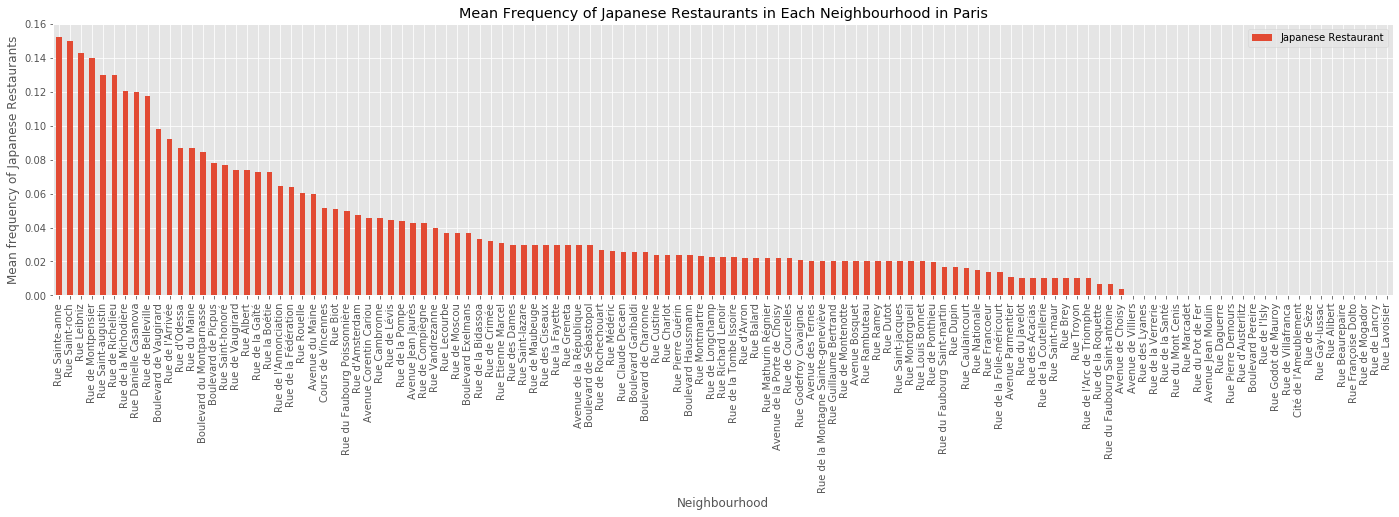

In [34]:
# sort by descending order
Paris_grouped.sort_values(by='Japanese Restaurant', ascending=False, inplace=True)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')
Paris_grouped.plot(kind='bar', figsize=(24,5))

plt.title('Mean Frequency of Japanese Restaurants in Each Neighbourhood in Paris')
plt.xlabel('Neighbourhood')
plt.ylabel('Mean frequency of Japanese Restaurants')

plt.show()

## Creating the final Dataframe for clustering

We will create a database of the neighbourhoods in Paris generated by foursquare. 

In [35]:
Test = Paris_venues.copy()
Test.drop_duplicates(['Neighborhood'], keep = 'first', inplace = True)
Test.drop(columns=['Venue','Venue Latitude','Venue Longitude','Venue Category'], inplace = True)

In [36]:
Test.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,Rue de l'Arrivée,48.843298,2.321696
76,Cité de l'Ameublement,48.850750,2.385743
121,Rue Charlot,48.861460,2.360837
205,Rue de la Tombe Issoire,48.826053,2.331825
249,Avenue de Choisy,48.820890,2.363820


In [37]:
Test.shape

(121, 3)

We will use the same website https://adresse.data.gouv.fr/csv to get the postal code of every neighbourhood in order to merge with the database wagepop (average wage per household & number of population per district).

In [38]:
url4 = '/Users/davidhinh/Desktop/Restaurant Data Base/PostalCodeParisVenues.csv'
postalcodeneigh = pd.read_csv(url4)
postalcodeneigh.head()

,Neighborhood,latitude,longitude,Postal Code
0,Rue de l'Arrivée,48.843690,2.322940,75015
1,Cité de l'Ameublement,48.850575,2.385576,75011
2,Rue Charlot,48.860666,2.359843,75003
3,Rue de la Tombe Issoire,48.832837,2.335976,75014
4,Avenue de Choisy,48.820245,2.364328,75013


In [39]:
postalcodeneigh['Postal Code'] = postalcodeneigh['Postal Code'].astype(int)
dfwagepop['Postal Code'] = dfwagepop['Postal Code'].astype(int)

In [40]:
ffwagepop = postalcodeneigh.merge(dfwagepop, on='Postal Code', how = 'inner')

In [226]:
ffwagepop.head()

,Neighborhood,latitude,longitude,Postal Code,District Average Wage Per Household €,District population 2018
0,Rue de l'Arrivée,48.843690,2.322940,75015,2695,234994
1,Rue de Vaugirard,48.844827,2.319498,75015,2695,234994
2,Avenue du Maine,48.844752,2.320214,75015,2695,234994
3,Rue Mathurin Régnier,48.840948,2.306902,75015,2695,234994
4,Rue de Villafranca,48.831845,2.303805,75015,2695,234994


In [41]:
ffdf = pd.merge(ffwagepop, Paris_grouped, on='Neighborhood')

In [42]:
ffdf.head()

,Neighborhood,latitude,longitude,Postal Code,District Average Wage Per Household €,District population 2018,Japanese Restaurant
0,Rue de l'Arrivée,48.843690,2.322940,75015,2695,234994,0.092105
1,Rue de Vaugirard,48.844827,2.319498,75015,2695,234994,0.074074
2,Avenue du Maine,48.844752,2.320214,75015,2695,234994,0.060000
3,Rue Mathurin Régnier,48.840948,2.306902,75015,2695,234994,0.022222
4,Rue de Villafranca,48.831845,2.303805,75015,2695,234994,0.000000


## Normalizing the data

Normalizing data helps to compare and interpret different features with different magnitude. StandardScaler() is used to normalized.

In [43]:
from sklearn.preprocessing import StandardScaler
X = ffdf.values[:,4:]
X = np.nan_to_num(X)
Clus = StandardScaler().fit_transform(X)
Clus 

array([[ 0.21732629,  1.45592224,  1.62179444],
       [ 0.21732629,  1.45592224,  1.12224545],
       [ 0.21732629,  1.45592224,  0.73232722],
       [ 0.21732629,  1.45592224, -0.31429542],
       [ 0.21732629,  1.45592224, -0.92995579],
       [ 0.21732629,  1.45592224,  1.78619291],
       [ 0.21732629,  1.45592224,  0.73900305],
       [ 0.21732629,  1.45592224,  0.09614483],
       [ 0.21732629,  1.45592224, -0.21957844],
       [ 0.21732629,  1.45592224, -0.31429542],
       [ 0.21732629,  1.45592224, -0.37586145],
       [ 0.21732629,  1.45592224,  1.40658659],
       [ 0.21732629,  1.45592224,  0.83843039],
       [ 0.21732629,  1.45592224,  0.32934952],
       [-0.48318326,  0.24389482, -0.92995579],
       [-0.48318326,  0.24389482, -0.74525768],
       [-0.48318326,  0.24389482, -0.65290862],
       [-0.48318326,  0.24389482, -0.37586145],
       [-0.48318326,  0.24389482, -0.37586145],
       [-0.48318326,  0.24389482, -0.62550835],
       [-0.48318326,  0.24389482, -0.346

In [44]:
df_normalized = pd.DataFrame(Clus)
df_normalized.rename(columns={0:'Normalized Household Income', 1:' Normalized Number of Residents', 2:'Normalized Number of Japanese Restaurants'}, inplace=True)
df_normalized.head()

,Normalized Household Income,Normalized Number of Residents,Normalized Number of Japanese Restaurants
0,0.217326,1.455922,1.621794
1,0.217326,1.455922,1.122245
2,0.217326,1.455922,0.732327
3,0.217326,1.455922,-0.314295
4,0.217326,1.455922,-0.929956


## Finding the best K for K-means clustering

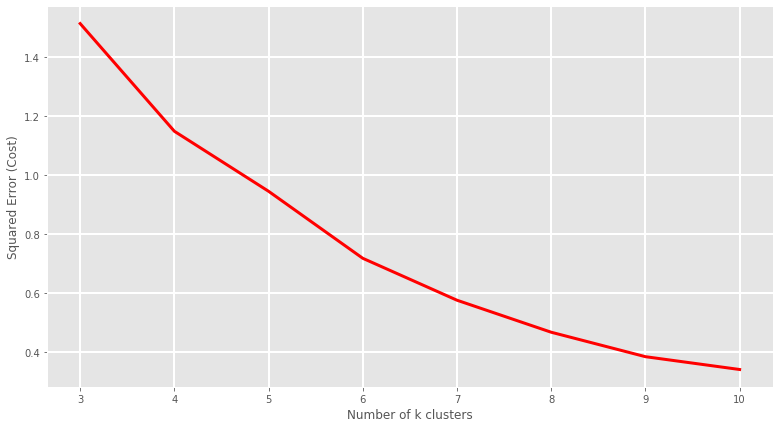

In [45]:
from sklearn.cluster import KMeans

error_cost=[]

for i in range(3, 11):
  KM = KMeans(n_clusters=i, max_iter=100)
  try:
    KM.fit(df_normalized)

  except ValueError:
    print('Error on line', i)

  # calculate squared error for the clustered points
  error_cost.append(KM.inertia_ / 100)

# plot the K values against the squared error cost
plt.figure(figsize=(13,7))
plt.plot(range(3,11), error_cost, color='r', linewidth=3)
plt.xlabel('Number of k clusters')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)

plt.show()

Taking a very small K value will not minimize the cost function. K = 6 seems to be a good value 

In [46]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_normalized)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([5, 5, 5, 4, 4, 5, 5, 5, 4, 4], dtype=int32)

Create a new dataframe that includes the cluster

In [47]:
df_clustered = pd.merge(ffdf, df_normalized, left_index=True, right_index=True)
df_clustered.insert(0, 'Cluster Label', kmeans.labels_)

In [48]:
df_clustered.head()

,Cluster Label,Neighborhood,latitude,longitude,Postal Code,District Average Wage Per Household €,District population 2018,Japanese Restaurant,Normalized Household Income,Normalized Number of Residents,Normalized Number of Japanese Restaurants
0,5,Rue de l'Arrivée,48.843690,2.322940,75015,2695,234994,0.092105,0.217326,1.455922,1.621794
1,5,Rue de Vaugirard,48.844827,2.319498,75015,2695,234994,0.074074,0.217326,1.455922,1.122245
2,5,Avenue du Maine,48.844752,2.320214,75015,2695,234994,0.060000,0.217326,1.455922,0.732327
3,4,Rue Mathurin Régnier,48.840948,2.306902,75015,2695,234994,0.022222,0.217326,1.455922,-0.314295
4,4,Rue de Villafranca,48.831845,2.303805,75015,2695,234994,0.000000,0.217326,1.455922,-0.929956


In [49]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude,longitude], zoom_start=12)

# set color schemes for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_clustered['latitude'], df_clustered['longitude'], df_clustered['Neighborhood'], df_clustered['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

### Cluster 0

In [50]:
df_clustered.loc[df_clustered['Cluster Label'] == 0]

,Cluster Label,Neighborhood,latitude,longitude,Postal Code,District Average Wage Per Household €,District population 2018,Japanese Restaurant,Normalized Household Income,Normalized Number of Residents,Normalized Number of Japanese Restaurants
82,0,Avenue Bosquet,48.861594,2.301895,75007,3896,54133,0.020000,2.413963,-1.118156,-0.375861
98,0,Rue de Ponthieu,48.870005,2.311514,75008,3739,36694,0.019841,2.126809,-1.366354,-0.380259
99,0,Rue Saint-honoré,48.867928,2.324380,75008,3739,36694,0.076923,2.126809,-1.366354,1.201176
100,0,Rue de Moscou,48.879746,2.326561,75008,3739,36694,0.037037,2.126809,-1.366354,0.096145
101,0,Rue la Boétie,48.874466,2.319677,75008,3739,36694,0.072464,2.126809,-1.366354,1.077632
102,0,Rue Lavoisier,48.873690,2.322177,75008,3739,36694,0.000000,2.126809,-1.366354,-0.929956
103,0,Rue de l'Isly,48.874762,2.326420,75008,3739,36694,0.000000,2.126809,-1.366354,-0.929956
106,0,Rue de l'Annonciation,48.855642,2.280771,75016,3509,165487,0.064516,1.706138,0.466674,0.857445
107,0,Rue de Longchamp,48.864798,2.293033,75016,3509,165487,0.022727,1.706138,0.466674,-0.300303
108,0,Rue de la Pompe,48.858518,2.274850,75016,3509,165487,0.044118,1.706138,0.466674,0.292311


High Spending power / Low & high population number / average competition

### Cluster 1

In [51]:
df_clustered.loc[df_clustered['Cluster Label'] == 1]

,Cluster Label,Neighborhood,latitude,longitude,Postal Code,District Average Wage Per Household €,District population 2018,Japanese Restaurant,Normalized Household Income,Normalized Number of Residents,Normalized Number of Japanese Restaurants
34,1,Avenue de Choisy,48.820245,2.364328,75013,2023,183216,0.003546,-1.011766,0.718999,-0.831712
35,1,Rue Vandrezanne,48.828192,2.356282,75013,2023,183216,0.040000,-1.011766,0.718999,0.178233
36,1,Rue Françoise Dolto,48.829385,2.382952,75013,2023,183216,0.000000,-1.011766,0.718999,-0.929956
37,1,Rue Nationale,48.821872,2.369142,75013,2023,183216,0.014706,-1.011766,0.718999,-0.522533
38,1,Avenue de la Porte de Choisy,48.817737,2.366293,75013,2023,183216,0.022222,-1.011766,0.718999,-0.314295
39,1,Rue du Javelot,48.826193,2.365315,75013,2023,183216,0.010417,-1.011766,0.718999,-0.641365
61,1,Boulevard de Charonne,48.848506,2.399505,75020,1721,195556,0.025641,-1.564126,0.894627,-0.219578
62,1,Rue des Lyanes,48.862755,2.406363,75020,1721,195556,0.000000,-1.564126,0.894627,-0.929956
63,1,Cours de Vincennes,48.848452,2.399542,75020,1721,195556,0.051724,-1.564126,0.894627,0.503047
65,1,Rue d'Avron,48.851465,2.398697,75020,1721,195556,0.022222,-1.564126,0.894627,-0.314295


Low income / very populated district / low competition

### Cluster 2

In [52]:
df_clustered.loc[df_clustered['Cluster Label'] == 2]

,Cluster Label,Neighborhood,latitude,longitude,Postal Code,District Average Wage Per Household €,District population 2018,Japanese Restaurant,Normalized Household Income,Normalized Number of Residents,Normalized Number of Japanese Restaurants
25,2,Rue Charlot,48.860666,2.359843,75003,2803,35049,0.023810,0.414859,-1.389766,-0.270320
26,2,Rue Greneta,48.865408,2.353128,75003,2803,35049,0.030000,0.414859,-1.389766,-0.098814
27,2,Boulevard de Sébastopol,48.862088,2.350445,75003,2803,35049,0.030000,0.414859,-1.389766,-0.098814
28,2,Rue Rambuteau,48.860188,2.356768,75003,2803,35049,0.020000,0.414859,-1.389766,-0.375861
43,2,Rue Etienne Marcel,48.863569,2.350696,75002,2724,20796,0.030612,0.270367,-1.592620,-0.081852
45,2,Rue Montmartre,48.865060,2.344866,75002,2724,20796,0.023333,0.270367,-1.592620,-0.283512
47,2,Rue Montorgueil,48.864615,2.346638,75002,2724,20796,0.020000,0.270367,-1.592620,-0.375861
86,2,Rue de Mogador,48.873431,2.331065,75009,2974,59408,0.000000,0.727619,-1.043080,-0.929956
87,2,Boulevard Haussmann,48.872087,2.338386,75009,2974,59408,0.023810,0.727619,-1.043080,-0.270320
88,2,Rue de Sèze,48.870482,2.326544,75009,2974,59408,0.000000,0.727619,-1.043080,-0.929956


high spending power / low number of population / low competition

### Cluster 3

In [53]:
df_clustered.loc[df_clustered['Cluster Label'] == 3]

,Cluster Label,Neighborhood,latitude,longitude,Postal Code,District Average Wage Per Household €,District population 2018,Japanese Restaurant,Normalized Household Income,Normalized Number of Residents,Normalized Number of Japanese Restaurants
41,3,Rue Sainte-anne,48.867067,2.335991,75002,2724,20796,0.1525,0.270367,-1.592620,3.295014
42,3,Rue Saint-augustin,48.868824,2.338254,75002,2724,20796,0.1300,0.270367,-1.592620,2.671657
44,3,Rue Danielle Casanova,48.867657,2.333318,75002,2724,20796,0.1200,0.270367,-1.592620,2.394610
46,3,Rue de Richelieu,48.866739,2.337334,75002,2724,20796,0.1300,0.270367,-1.592620,2.671657
116,3,Rue de Montpensier,48.863883,2.336132,75001,2862,16545,0.1400,0.522770,-1.653122,2.948705
117,3,Rue Saint-roch,48.864220,2.331394,75001,2862,16545,0.1500,0.522770,-1.653122,3.225752


high spending / low number of population / high competition

### Cluster 4

In [85]:
cluster4 = df_clustered.loc[df_clustered['Cluster Label'] == 4]
cluster4

,Cluster Label,Neighborhood,latitude,longitude,Postal Code,District Average Wage Per Household €,District population 2018,Japanese Restaurant,Normalized Household Income,Normalized Number of Residents,Normalized Number of Japanese Restaurants
3,4,Rue Mathurin Régnier,48.840948,2.306902,75015,2695,234994,0.022222,0.217326,1.455922,-0.314295
4,4,Rue de Villafranca,48.831845,2.303805,75015,2695,234994,0.000000,0.217326,1.455922,-0.929956
8,4,Boulevard Garibaldi,48.847795,2.302753,75015,2695,234994,0.025641,0.217326,1.455922,-0.219578
9,4,Rue Balard,48.845455,2.277199,75015,2695,234994,0.022222,0.217326,1.455922,-0.314295
10,4,Rue Dutot,48.839262,2.309423,75015,2695,234994,0.020000,0.217326,1.455922,-0.375861
14,4,Cité de l'Ameublement,48.850575,2.385576,75011,2312,149834,0.000000,-0.483183,0.243895,-0.929956
15,4,Rue de la Roquette,48.853718,2.370599,75011,2312,149834,0.006667,-0.483183,0.243895,-0.745258
16,4,Rue Saint-maur,48.858686,2.383386,75011,2312,149834,0.010000,-0.483183,0.243895,-0.652909
17,4,Rue Guillaume Bertrand,48.863183,2.379417,75011,2312,149834,0.020000,-0.483183,0.243895,-0.375861
18,4,Rue Louis Bonnet,48.870375,2.376418,75011,2312,149834,0.020000,-0.483183,0.243895,-0.375861


mid speending power / high residents number / average competition

### Cluster 5

In [55]:
df_clustered.loc[df_clustered['Cluster Label'] == 5]

,Cluster Label,Neighborhood,latitude,longitude,Postal Code,District Average Wage Per Household €,District population 2018,Japanese Restaurant,Normalized Household Income,Normalized Number of Residents,Normalized Number of Japanese Restaurants
0,5,Rue de l'Arrivée,48.843690,2.322940,75015,2695,234994,0.092105,0.217326,1.455922,1.621794
1,5,Rue de Vaugirard,48.844827,2.319498,75015,2695,234994,0.074074,0.217326,1.455922,1.122245
2,5,Avenue du Maine,48.844752,2.320214,75015,2695,234994,0.060000,0.217326,1.455922,0.732327
5,5,Boulevard de Vaugirard,48.841637,2.319769,75015,2695,234994,0.098039,0.217326,1.455922,1.786193
6,5,Rue Rouelle,48.850308,2.287211,75015,2695,234994,0.060241,0.217326,1.455922,0.739003
7,5,Rue Lecourbe,48.844861,2.310567,75015,2695,234994,0.037037,0.217326,1.455922,0.096145
11,5,Boulevard du Montparnasse,48.846604,2.316556,75015,2695,234994,0.084337,0.217326,1.455922,1.406587
12,5,Rue de la Fédération,48.855026,2.289944,75015,2695,234994,0.063830,0.217326,1.455922,0.838430
13,5,Rue Cambronne,48.847396,2.301759,75015,2695,234994,0.045455,0.217326,1.455922,0.329350
30,5,Rue d'Odessa,48.843182,2.324402,75014,2394,139992,0.086957,-0.333205,0.103820,1.479150


mid spending power /  high residents number / high competition

Regarding the concept of Izakaya, we are looking for a populated district, where residents have mid/high spending power and there is average competition. The cluster number 4 seems to be the most appropriate.

## More analysis on cluster 4

In [86]:
cluster4.groupby('Postal Code').count()

,Cluster Label,Neighborhood,latitude,longitude,District Average Wage Per Household €,District population 2018,Japanese Restaurant,Normalized Household Income,Normalized Number of Residents,Normalized Number of Japanese Restaurants
Postal Code,,,,,,,,,,
75010,8,8,8,8,8,8,8,8,8,8
75011,11,11,11,11,11,11,11,11,11,11
75012,2,2,2,2,2,2,2,2,2,2
75014,3,3,3,3,3,3,3,3,3,3
75015,5,5,5,5,5,5,5,5,5,5
75017,12,12,12,12,12,12,12,12,12,12


Let's use data scrapped from tripadvisor to see what offer the existing successful japanese restaurants near the same location are offering.

In [104]:
bestjap = japaneserest.loc[(japaneserest['Number of Reviews'] > 30) & (japaneserest['Rating'] >= 4) & (japaneserest['Rating'] >= 4)]

In [106]:
bestjap.loc[bestjap['Insee Code'].isin(['75110','75111','75112','75114','75117'])]

,Name,City,Cuisine Style,Rating,Price Range,Number of Reviews,Reviews,Borough,Neighborhood,Address,Insee Code,Latitude,Longitude
2806,Kazoku,Paris,Japanese,4.0,$,90.0,Great price - good quantity but adequate qu,Paris 14e,Rue de la Tombe Issoire,105 Rue de la Tombe Issoire 75014 Paris,75114.0,48.826053,2.331825
3737,Shook,Paris,Japanese,4.5,$$ - $$$,71.0,A good plan - Always a pleasure coming here,Paris 11e,Rue de la Roquette,8 Rue de la Roquette 75011 Paris,75111.0,48.853485,2.370625
3848,Zenzan,Paris,Japanese,4.0,$$ - $$$,70.0,Average - but high price - Very good,Paris 17e,Rue Brey,4 Rue Brey 75017 Paris,75117.0,48.876165,2.296262
4575,Kyobashi,Paris,Japanese,4.5,$$ - $$$,65.0,Super friendly staff - and delicious food - Mo...,Paris 11e,Rue Saint-maur,117 Rue Saint-maur 75011 Paris,75111.0,48.866291,2.376661
4001,Toyama,Paris,Japanese,4.0,$$ - $$$,63.0,Jap style restaurand - Very nice sushi restaurant,Paris 14e,Rue d'Odessa,14 Rue d'Odessa 75014 Paris,75114.0,48.842297,2.324454
4003,Toyama,Paris,Japanese,4.0,$$ - $$$,63.0,Jap style restaurand - Very nice sushi restaurant,Paris 11e,Boulevard de Charonne,109 Boulevard de Charonne 75011 Paris,75111.0,48.856084,2.394406
2687,Yamada,Paris,Japanese,4.5,$$ - $$$,60.0,Very good food - Fantastic - good -value sushi,Paris 10e,Rue du Faubourg Saint-martin,188 Rue du Faubourg Saint-martin 75010 Paris,75110.0,48.878671,2.362421
4033,Teppanyaki Sushi,Paris,Japanese,4.0,$$ - $$$,60.0,Thought of best Japanese food,Paris 17e,Rue de Lévis,88 Rue de Lévis 75017 Paris,75117.0,48.884722,2.311877
5435,Naoki,Paris,Japanese,4.5,$$ - $$$,59.0,Authentic - Excellent Japanese,Paris 11e,Rue Guillaume Bertrand,5 Rue Guillaume Bertrand 75011 Paris,75111.0,48.863356,2.379793
4533,Robata,Paris,Japanese,4.0,$$ - $$$,57.0,Very nice food stop - Great service and good food,Paris 12e,Rue Claude Decaen,96 Rue Claude Decaen 75012 Paris,75112.0,48.838740,2.396308


What emerges is that all restaurants offer a rather low price range. The next step of analysis would be to check the offer of each successful restaurant.

After analyzing the age of the population of the district, it seems that the population is quite homogeneous in every district. the majority of the residents in Paris belongs to the young working class, which is good for Izakaya concept.

In [281]:
dfage

,Age,75001,75002,75003,75004,75005,75006,75007,75008,75009,75010,75011,75012,75013,75014,75015,75016,75017,75018,75019,75020
0,0-14,11.8,12,11.4,11.4,11.4,10.2,12.1,15.1,14,14.9,12,13.4,13.7,12.6,13.6,14.6,14.3,14,17,15.1
1,15-29,22.1,26.2,25.9,24.5,29.2,27.6,23.6,23.7,25,23.5,24.7,22.7,23.7,26.3,24.2,20.8,23.9,23.5,21.9,20.9
2,30-44,22.7,27.3,25.2,21.6,17.3,16.4,17.3,20.2,25.4,26.7,25.4,22.4,20.3,19.9,21.4,17.1,23.1,26.5,21.7,23.1
3,45-49,20.3,19.8,19.2,19.3,16.9,16.9,18.2,18.7,17.8,18.5,17.8,18.5,19,17.2,17.6,19.7,17.9,18,19.2,20
4,60-74,14.9,10.6,12.5,15.3,15.5,17.3,17.3,14.8,11.8,11.4,13.6,14.3,15.2,15.1,14.3,16.3,13.5,12.2,13.7,14.4
5,75+,8.1,4.1,5.8,7.8,9.5,11.5,11.5,7.6,6,4.9,6.5,8.7,8.1,8.9,8.9,11.5,7.3,5.8,6.5,6.5


### BONUS

With more data, for example the population density per m2 for each neighbourhood, we can determine whether the flow of customers could be good. The number of residents in a neighbourhood is not relevant, but it can give us a potential number of clients. The location of parking lots or public transport close to the chosen location, the more accessible the location, the more customers there will be. If there are a lot of offices around the location that have their own self to assess the number of potential customers at lunchtime.